# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/v5kXkk

Videos:

TA: ntu-ml-2021spring-ta@googlegroups.com

## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [ ]:
import torch
try:
    # Get GPU name, check if it's K80
    GPU_name = torch.cuda.get_device_name()
    if GPU_name[-3:] == "K80":
        print("Get K80! :'( RESTART!")
        exit()  # Restart the session
    else:
        print("Your GPU is {}!".format(GPU_name))
        print("Great! Keep going~")
except RuntimeError as e:
    if e.args == ("No CUDA GPUs are available",):
        print("You are training with CPU! "
              "Please restart!")
        exit()  # Restart the session
    else:
        print("What's wrong here?")
        print("Error message: \n", e)

Your GPU is Tesla P100-PCIE-16GB!
Great! Keep going~


In [ ]:
# set up environment
!pip install pytorchcv

# download
!gdown --id 1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX -O data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip

     |████████████████████████████████| 532kB 7.5MB/s 
Downloading...
From: https://drive.google.com/uc?id=1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX
To: /content/data.zip
100% 490k/490k [00:00<00:00, 66.1MB/s]
Archive:  ./data.zip
   creating: data/
   creating: data/deer/
 extracting: data/deer/deer13.png    
 extracting: data/deer/deer6.png     
 extracting: data/deer/deer11.png    
 extracting: data/deer/deer2.png     
 extracting: data/deer/deer10.png    
 extracting: data/deer/deer16.png    
 extracting: data/deer/deer9.png     
 extracting: data/deer/deer20.png    
 extracting: data/deer/deer15.png    
 extracting: data/deer/deer19.png    
 extracting: data/deer/deer5.png     
 extracting: data/deer/deer14.png    
 extracting: data/deer/deer4.png     
 extracting: data/deer/deer8.png     
 extracting: data/deer/deer12.png    
 extracting: data/deer/deer1.png     
 extracting: data/deer/deer7.png     
 extracting: data/deer/deer17.png    
 extracting: data/deer/deer18.png    
 extracting:

## Global Settings

* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std
# TODO: iterative fgsm attack
# alpha (step size) can be decided by yourself
alpha = 0.8/255/std

root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [ ]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [ ]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [ ]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    
    return x_adv

# TODO: perform iterative fgsm attack
# set alpha as the step size in Global Settings section
# alpha and num_iter can be decided by yourself
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    # initialize x_adv as original benign image x
    x_adv = x.detach().clone()
    # write a loop of num_iter to represent the iterative times
    # for each loop
    for i in range(num_iter):
        # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv = fgsm(model, x_adv ,y, loss_fn, alpha)
        # clip new x_adv back to [x-epsilon, x+epsilon]
        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon)
    return x_adv
    #pass

## Utils -- Attack

* Recall
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
    * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
    * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
    * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
    * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [ ]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    #for model in models:
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [ ]:
### Ensemble approach: ###
class Ensemble(nn.Module):
    def __init__(self, model1, model2, model3, model4, model5, model6, model7):
        super(Ensemble, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.model4 = model4
        self.model5 = model5
        self.model6 = model6
        self.model7 = model7

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        out4 = self.model4(x)
        out5 = self.model5(x)
        out6 = self.model6(x)
        out7 = self.model7(x)


        # sum all the model's output and 取平均 
        out = out1 + out2 + out3 + out4 + out5 + out6 + out7
        avg_out = out / 7
        #print(avg_out)
        #print('.........................')

        return torch.softmax(avg_out, dim=1)

# Referred from https://www.kaggle.com/iamsdt/ensemble-model-pytorch (Ensembling section)

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model
# model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)

# Model list for ensemble:
model1 = ptcv_get_model('resnet110_cifar10', pretrained=True)
model2 = ptcv_get_model('resnet164bn_cifar10', pretrained=True)
model3 = ptcv_get_model('resnet542bn_cifar10', pretrained=True)
model4 = ptcv_get_model('densenet100_k12_bc_cifar10', pretrained=True)
model5 = ptcv_get_model('resnext29_16x64d_cifar10', pretrained=True)
# model5 = ptcv_get_model('densenet190_k40_bc_cifar10', pretrained=True)
model6 = ptcv_get_model('resnet56_cifar10', pretrained=True)
model7 = ptcv_get_model('resnext29_32x4d_cifar10', pretrained=True)


model = Ensemble(model1,model2,model3,model4,model5,model6,model7).to(device)

loss_fn = nn.CrossEntropyLoss()
benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

benign_acc = 0.95500, benign_loss = 1.52005


#### Results summary

##### **原始1~7個model:**
1. ensemble 前3個 (acc: 0.110)
2. ensemble 前5個 (acc: 0.090)
3. ensemble 前6個 (acc: 0.070)
4. ensemble 7個   (acc: 0.010(lucky), 0.070) 

##### **將model5換成resnext29_16x64d_cifar10後,** 
1. ensemble 7個   (acc: 0.040)

## FGSM

In [ ]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

fgsm_acc = 0.60000, fgsm_loss = 1.90101


## I-FGSM

In [ ]:
# TODO: iterative fgsm attack
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)

ifgsm_acc = 0.02000, ifgsm_loss = 2.44207


## Compress the images

In [ ]:
# %cd fgsm
# !tar zcvf ../fgsm.tgz *
# %cd ..

%cd ifgsm
!tar zcvf ../ifgsm.tgz *
%cd ..

/content/ifgsm
airplane/
airplane/airplane11.png
airplane/airplane19.png
airplane/airplane17.png
airplane/airplane6.png
airplane/airplane10.png
airplane/airplane12.png
airplane/airplane20.png
airplane/airplane8.png
airplane/airplane16.png
airplane/airplane14.png
airplane/airplane1.png
airplane/airplane2.png
airplane/airplane13.png
airplane/airplane3.png
airplane/airplane4.png
airplane/airplane18.png
airplane/airplane7.png
airplane/airplane15.png
airplane/airplane9.png
airplane/airplane5.png
automobile/
automobile/automobile16.png
automobile/automobile18.png
automobile/automobile3.png
automobile/automobile10.png
automobile/automobile19.png
automobile/automobile13.png
automobile/automobile17.png
automobile/automobile15.png
automobile/automobile11.png
automobile/automobile9.png
automobile/automobile20.png
automobile/automobile8.png
automobile/automobile2.png
automobile/automobile4.png
automobile/automobile7.png
automobile/automobile1.png
automobile/automobile12.png
automobile/automobile14

## Visualization

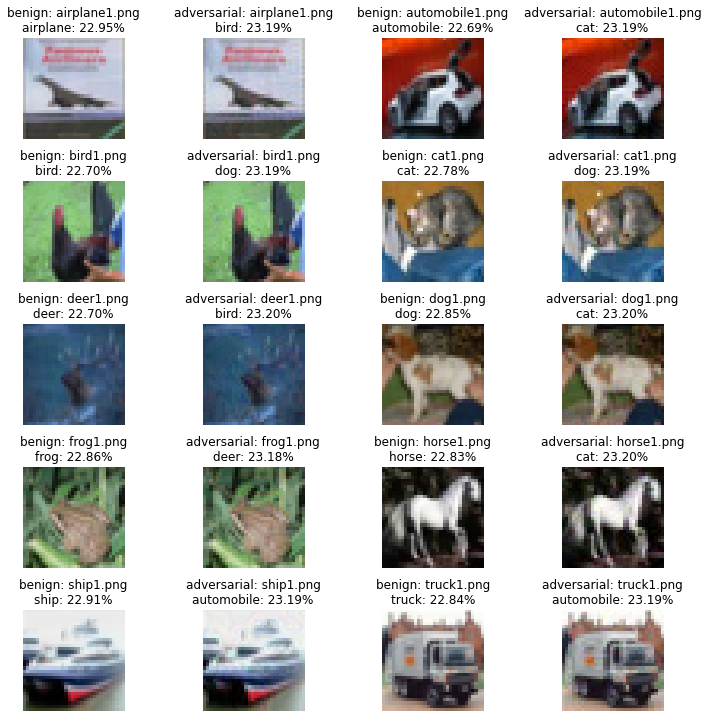

In [ ]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./ifgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

## Reference:
1. Ensembling approach: https://www.kaggle.com/iamsdt/ensemble-model-pytorch 